In [286]:
from gurobipy import *
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, Colormap, ListedColormap, LinearSegmentedColormap
import seaborn as sns
from shapely.geometry import Point
plt.rcParams['font.sans-serif'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False

In [243]:
def draw_map():
    # 讀取台灣地圖 shapefile 檔案
    df_taiwan = gpd.read_file('data/Taiwan//COUNTY_MOI_1090820.shp', encoding='utf-8')
    # 繪製台灣地圖
    xmin, ymin, xmax, ymax = 119.8, 21.7, 122.5, 25.5
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    df_taiwan.plot(ax=ax, edgecolor='gray', facecolor='lightgray')
    for idx, row in df_taiwan.iterrows():
            ax.annotate(text=row['COUNTYNAME'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=12, c = "grey")



### Parameters

In [100]:
df_county = pd.read_csv('data/county_code.csv')
df_market = pd.read_csv('data/market_code.csv')
I = range(df_county.shape[0])
J = range(df_market.shape[0])

In [50]:
df_demand = pd.read_excel("data/demand_function.xlsx")
A = df_demand["slope"]
B = df_demand["intercept"]

In [51]:
# 旺季產量
df_production = pd.read_csv("data/county_production.csv")
# 旺季一個月
df_production1 = df_production.copy()
df_production1['quantity'] = df_production1['quantity'] * 0.6 / 4 
# 每天
df_production1['quantity'] /= 30
Q1_s = df_production1['quantity']
df_production1

,Unnamed: 0,name,quantity,code
0,0,新北市,15366.243889,0
1,1,台北市,2748.499444,1
2,2,桃園市,16033.365000,2
3,3,台中市,176370.740556,3
4,4,台南市,95918.435556,4
5,5,高雄市,38387.124444,5
6,6,宜蘭縣,431689.425000,6
7,7,新竹縣,37136.298333,7
8,8,苗栗縣,23024.741667,8
9,9,彰化縣,226593.761111,9


In [52]:
# 淡季
# 旺季一個月
df_production2 = df_production.copy()
df_production2['quantity'] = df_production2['quantity'] * 0.4 / 5 
# 每天
df_production2['quantity'] /= 30
Q2_s = df_production2['quantity']
df_production2

,Unnamed: 0,name,quantity,code
0,0,新北市,8195.330074,0
1,1,台北市,1465.866370,1
2,2,桃園市,8551.128000,2
3,3,台中市,94064.394963,3
4,4,台南市,51156.498963,4
5,5,高雄市,20473.133037,5
6,6,宜蘭縣,230234.360000,6
7,7,新竹縣,19806.025778,7
8,8,苗栗縣,12279.862222,8
9,9,彰化縣,120850.005926,9


In [136]:
L = 2500
C_t = 0.03
C_p = 7.5
M = 6800 - 2500

In [54]:
df_s2m = pd.read_excel("data/s2m.xlsx")
D = df_s2m.iloc[:, 1:]

In [55]:
# consumption
df_consumption = pd.read_csv("data/consumption.csv")
df_consumption = df_consumption.replace("南投市", "南投市場")
df_consumption = df_consumption[df_consumption["market_name"].isin(list(df_demand["Unnamed: 0"]))]
df_consumption["month"] = df_consumption["date"].str.split('.').str[1]
consumptions = []
month = df_consumption["month"].unique()
for i in month:
    df = df_consumption[df_consumption["month"] == i][["market_name", 
                        "quantity", "mean_price"]].groupby(["market_name"]).mean()
    df = df_demand[["Unnamed: 0"]].merge(right = df, right_on = "market_name", left_on = "Unnamed: 0")
    consumptions.append(df)

print(consumptions)

[   Unnamed: 0       quantity  mean_price
0         台北二  157183.655977   13.280257
1         台北一  378746.411079   13.322492
2         三重區   50967.553936   12.080210
3          桃農   32963.338192   12.052526
4         台中市   42682.312865   11.989855
5         永靖鄉   56868.415441    9.967664
6         溪湖鎮   84505.971098   12.446673
7        南投市場    2919.810496   14.902399
8         西螺鎮  379836.636637   11.044560
9         高雄市   79209.460641   15.881483
10        鳳山區   24236.137026   11.331352
11        屏東市   33785.737609   12.140778
12        花蓮市   25497.405917   15.766917
13        台東市   14901.787582   15.333606
14        宜蘭市   20436.245353    9.801510
15        豐原區   40815.417040   10.716375
16        板橋區   88827.083436   12.826775,    Unnamed: 0       quantity  mean_price
0         台北二  150816.038328   11.141501
1         台北一  361029.118467   11.116382
2         三重區   48038.578397   10.238284
3          桃農   29528.552448   10.027633
4         台中市   40475.560976   10.075852
5         永靖鄉 

In [56]:
meanDis = []
for i, row in D.iterrows():
    meanDis.append(row.mean())

In [137]:
quantity = []
for j in J:
    p = C_p
    print(p)
    quantity.append((p - B[j]) / A[j])
quantity

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


[379583.3333333333,
 773833.3333333333,
 100395.0,
 185320.0,
 97375.0,
 72820.0,
 152770.0,
 4869.090909090909,
 734966.6666666666,
 222289.99999999997,
 33840.0,
 86415.0,
 50235.0,
 98495.0,
 35072.857142857145,
 93454.99999999999,
 207611.1111111111]

In [135]:
Q1_d

0     157183.655977
1     378746.411079
2      50967.553936
3      32963.338192
4      42682.312865
5      56868.415441
6      84505.971098
7       2919.810496
8     379836.636637
9      79209.460641
10     24236.137026
11     33785.737609
12     25497.405917
13     14901.787582
14     20436.245353
15     40815.417040
16     88827.083436
Name: quantity, dtype: float64

In [128]:
df_cost = pd.read_excel("data/cost.xlsx")
C = df_cost["mc"]

- Desicion variables
$$
\begin{split}
    x_{ij} & = \mbox{kilogram of cabbage transported from county $i$ to market $j$} \\
    y_{ij} & = \mbox{number of truck from county $i$ to market $j$} \\
    d_j &= \mbox{differnce of kilogram between ideal quantity and real trading value in market $j$}
\end{split}
$$

- Parameters
$$
\begin{split}
    C^t & = \mbox{cost of transporting one kilogtram of things per kilometer} \\
    W & = \mbox{penalty weight of difference}  = 1000 \\
    D_{ij} & = \mbox{distance from county $i$ to market $j$} \\
    M & =  \mbox{kilogram of the truck} = \mbox{4300kg} \\
    Q^s_i & = \mbox{supply quantity of county $i$} \\
    Q^d_j & = \mbox{demand quantity of market $j$} \\
    Q_j & = \mbox{the ideal trading volume of market $j$} \\
    L & = \mbox{the volume of the truck} = \mbox{2500kg}
\end{split}
$$

- Formulation
$$
\begin{split}
 \mbox{min} \quad & C^t\sum_{i \in I}\sum_{j \in J}D_{ij}(My_{ij} + x_{ij}) + W\sum_{j \in J} {d_j} \quad \mbox{(carbon footprint + penalty)} \\
 \mbox{s.t.} \quad & \sum_j x_{ij} \leq Q^s_i \quad \forall i \in I \quad \mbox{(upper limit of production quantity)}\\
 & \sum_i x_{ij} \leq Q^d_j \quad \forall j \in J \quad \mbox{(upper limit of demand quantity)}\\
 & d_j \geq Q_j - \sum_{i \in I}x_{ij} \quad \forall j \in J \\
 & d_j \geq \sum_{i \in I}x_{ij} - Q_j \quad \forall j \in J \\
 & x_{ij} \leq y_{ij}L \quad \forall i \in I, j \in J \quad \mbox{(compute number of truck)}\\
 & x_{ij} \geq 0 \quad \forall i \in I, j \in J \quad \mbox{(Sign Constraint)} \\
 & y_{ij} \in \mathbb{Z}^+ \quad \forall i \in I, j \in J \\
\end{split}
$$

## 旺季

In [224]:
Q1 = quantity
W = 1000
Q1_d = consumptions[0]["quantity"]

# Calcalate directly from real price
model1 = Model('model1')

# decision variables
x = model1.addVars(I, J, lb = 0, vtype = GRB.CONTINUOUS, name = 'x')
y = model1.addVars(I, J, lb = 0, vtype = GRB.CONTINUOUS, name = 'y')
d = model1.addVars(J, lb = 0, vtype = GRB.CONTINUOUS, name = 'd')

# objective function
model1.setObjective(C_t * quicksum(D.iloc[j, i] * (M * y[i, j] + x[i, j]) for i in I for j in J) 
                    + W * quicksum(d[j] for j in J), GRB.MINIMIZE)


constr = model1.addConstrs(quicksum(x[i, j] for j in J) <= Q1_s[i] for i in I)
constr = model1.addConstrs(quicksum(x[i, j] for i in I) <= Q1_d[j] for j in J)
constr = model1.addConstrs(d[j] >= Q1[j] - quicksum(x[i, j] for i in I) for j in J)
onstr = model1.addConstrs(d[j] >= quicksum(x[i, j] for i in I) - Q1[j] for j in J)
constr = model1.addConstrs(x[i, j] <= y[i, j] * L for i in I for j in J)

model1.optimize()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 411 rows, 697 columns and 2074 nonzeros
Model fingerprint: 0x4f57adb0
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [9e-05, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 8e+05]
Presolve removed 340 rows and 340 columns
Presolve time: 0.00s
Presolved: 71 rows, 357 columns, 1394 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.161683e+05   0.000000e+00      0s
      87    1.8210514e+09   0.000000e+00   0.000000e+00      0s

Solved in 87 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.821051428e+09


- 分配安排

In [225]:
for var in model1.getVars():
    if var.varName.startswith('x'):
        print(var.varName, '=', var.x)
    if var.varName.startswith('y'):
        print(var.varName, '=', var.x)
    if var.varName.startswith('d'):
        print(var.varName, '=', var.x)

x[0,0] = 15366.24388888889
x[0,1] = 0.0
x[0,2] = 0.0
x[0,3] = 0.0
x[0,4] = 0.0
x[0,5] = 0.0
x[0,6] = 0.0
x[0,7] = 0.0
x[0,8] = 0.0
x[0,9] = 0.0
x[0,10] = 0.0
x[0,11] = 0.0
x[0,12] = 0.0
x[0,13] = 0.0
x[0,14] = 0.0
x[0,15] = 0.0
x[0,16] = 0.0
x[1,0] = 2748.499444444444
x[1,1] = 0.0
x[1,2] = 0.0
x[1,3] = 0.0
x[1,4] = 0.0
x[1,5] = 0.0
x[1,6] = 0.0
x[1,7] = 0.0
x[1,8] = 0.0
x[1,9] = 0.0
x[1,10] = 0.0
x[1,11] = 0.0
x[1,12] = 0.0
x[1,13] = 0.0
x[1,14] = 0.0
x[1,15] = 0.0
x[1,16] = 0.0
x[2,0] = 16033.364999999998
x[2,1] = 0.0
x[2,2] = 0.0
x[2,3] = 0.0
x[2,4] = 0.0
x[2,5] = 0.0
x[2,6] = 0.0
x[2,7] = 0.0
x[2,8] = 0.0
x[2,9] = 0.0
x[2,10] = 0.0
x[2,11] = 0.0
x[2,12] = 0.0
x[2,13] = 0.0
x[2,14] = 0.0
x[2,15] = 0.0
x[2,16] = 0.0
x[3,0] = 0.0
x[3,1] = 17199.29435299791
x[3,2] = 0.0
x[3,3] = 0.0
x[3,4] = 42682.31286549708
x[3,5] = 0.0
x[3,6] = 0.0
x[3,7] = 0.0
x[3,8] = 0.0
x[3,9] = 0.0
x[3,10] = 0.0
x[3,11] = 0.0
x[3,12] = 0.0
x[3,13] = 0.0
x[3,14] = 0.0
x[3,15] = 27662.049901477716
x[3,16] = 88827.

In [226]:
df_result_production = df_county.copy()
p = []
for i in I:
    total = 0
    for j in J:
        total += x[i, j].x
    p.append(total)
df_result_production["production"] = p
df_result_production

,Unnamed: 0,name,code,lat,lng,production
0,0,新北市,0,25.016983,121.462787,15366.243889
1,1,台北市,1,25.032964,121.565427,2748.499444
2,2,桃園市,2,24.991703,121.298959,16033.365000
3,3,台中市,3,24.147736,120.673648,176370.740556
4,4,台南市,4,22.999900,120.226876,24490.509166
5,5,高雄市,5,22.627278,120.301435,38387.124444
6,6,宜蘭縣,6,24.702107,121.737750,431689.425000
7,7,新竹縣,7,24.838723,121.017725,37136.298333
8,8,苗栗縣,8,24.560159,120.821427,23024.741667
9,9,彰化縣,9,24.051796,120.516135,226593.761111


- 歷史資料中實際生產量

In [192]:
Q1_s

0      15366.243889
1       2748.499444
2      16033.365000
3     176370.740556
4      95918.435556
5      38387.124444
6     431689.425000
7      37136.298333
8      23024.741667
9     226593.761111
10    233545.821111
11    458767.212222
12    117518.770556
13     74353.701667
14     31505.105000
15     19572.552778
16        23.720000
17       603.262222
18      1003.147222
19     12541.462500
Name: quantity, dtype: float64

In [227]:
df_result_consumption = df_market.copy()
c = []
for j in J:
    total = 0
    for i in I:
        total += x[i, j].x
    c.append(total)
df_result_consumption["consumption"] = c
df_result_consumption

,Unnamed: 0,name,code,lat,lng,consumption
0,0,台北二綜合農產品批發市場,0,25.017152,121.497170,157183.655977
1,1,台北一綜合農產品批發市場,1,25.017135,121.497064,378746.411079
2,2,三重區綜合農產品批發市場,2,25.065173,121.486490,50967.553936
3,3,桃農綜合農產品批發市場,3,24.990382,121.269176,32963.338192
4,4,台中市綜合農產品批發市場,4,24.199446,120.658159,42682.312865
5,5,永靖鄉綜合農產品批發市場,5,23.922792,120.550124,56868.415441
6,6,溪湖鎮綜合農產品批發市場,6,23.957270,120.486067,84505.971098
7,7,南投市綜合農產品批發市場,7,24.990382,121.269176,2919.810496
8,8,西螺鎮綜合農產品批發市場,8,23.796092,120.458872,379836.636637
9,9,高雄市綜合農產品批發市場,9,22.644275,120.315982,79209.460641


In [238]:
df1 = df_result_production.copy()
df1["type"] = "county"
df2 = df_result_consumption.copy()
df2["type"] = "market"
df_dots = pd.concat([df1, df2])
df_dots

,Unnamed: 0,name,code,lat,lng,production,type,consumption
0,0,新北市,0,25.016983,121.462787,15366.243889,county,NaN
1,1,台北市,1,25.032964,121.565427,2748.499444,county,NaN
2,2,桃園市,2,24.991703,121.298959,16033.365000,county,NaN
3,3,台中市,3,24.147736,120.673648,176370.740556,county,NaN
4,4,台南市,4,22.999900,120.226876,24490.509166,county,NaN
5,5,高雄市,5,22.627278,120.301435,38387.124444,county,NaN
6,6,宜蘭縣,6,24.702107,121.737750,431689.425000,county,NaN
7,7,新竹縣,7,24.838723,121.017725,37136.298333,county,NaN
8,8,苗栗縣,8,24.560159,120.821427,23024.741667,county,NaN
9,9,彰化縣,9,24.051796,120.516135,226593.761111,county,NaN


In [291]:
df_lines = pd.DataFrame(columns = ["lng", "lat", "x", "quantity"])
for i in I:
    for j in J:
        if(x[i, j].x > 0):
            n = len(df_lines.index)
            df_lines.loc[n] = [df1.lng[i], df1.lat[i], i, x[i, j].x]
            df_lines.loc[n+1] = [df2.lng[j], df2.lat[j], i, x[i, j].x]
df_lines

,lng,lat,x,quantity
0,121.462787,25.016983,0.0,15366.243889
1,121.497170,25.017152,0.0,15366.243889
2,121.565427,25.032964,1.0,2748.499444
3,121.497170,25.017152,1.0,2748.499444
4,121.298959,24.991703,2.0,16033.365000
...,...,...,...,...
57,121.497170,25.017152,16.0,23.720000
58,120.967480,24.813829,17.0,603.262222
59,121.497170,25.017152,17.0,603.262222
60,121.300980,24.993628,19.0,12541.462500


- 歷史資料中實際需求量

In [194]:
Q1_d

0     157183.655977
1     378746.411079
2      50967.553936
3      32963.338192
4      42682.312865
5      56868.415441
6      84505.971098
7       2919.810496
8     379836.636637
9      79209.460641
10     24236.137026
11     33785.737609
12     25497.405917
13     14901.787582
14     20436.245353
15     40815.417040
16     88827.083436
Name: quantity, dtype: float64

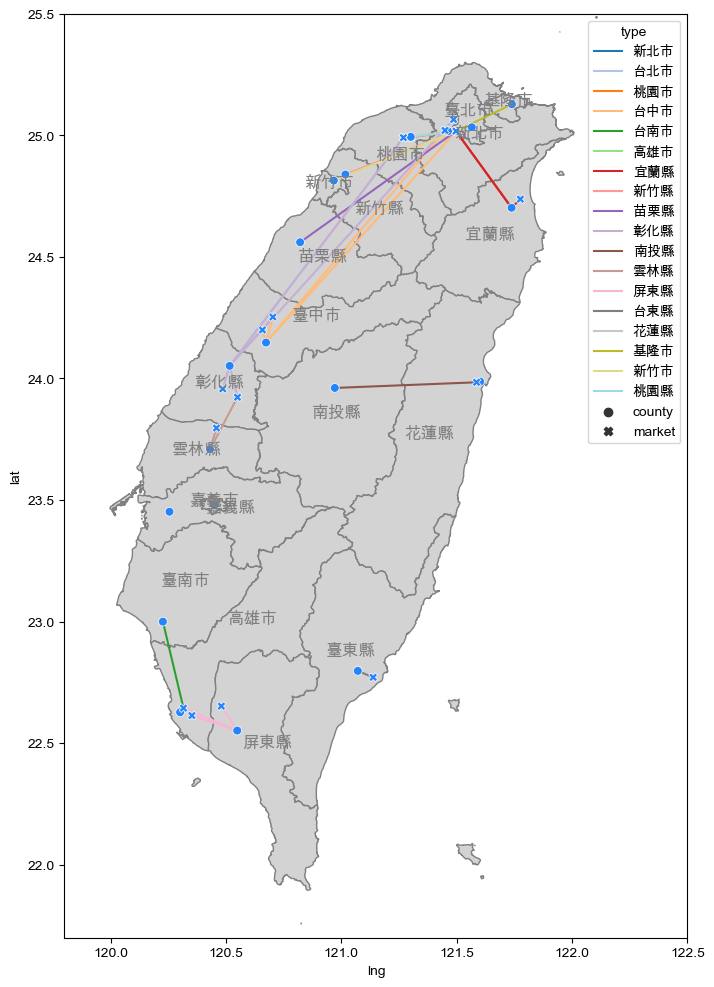

In [333]:
fig, ax = plt.subplots(figsize=(12, 12))
draw_map()
oranges = mpl.colormaps['Oranges']
cList = oranges(np.linspace(0.1, 1, ))
cmap = ListedColormap(oranges(np.linspace(0.1, 1, len(I))))
color_map = plt.cm.get_cmap('tab20')
# sns.lineplot(data = df_lines, x = "lng", y = "lat")
labels = []
for i in I:
    for j in J:
        if x[i, j].x > 0:
            if df1.name[i] not in labels:
                label = df1.name[i]
                labels.append(label)
            else:
                label = None
            plt.plot([df1.lng[i], df2.lng[j]], [df1.lat[i], df2.lat[j]], color = color_map(i), label = label)

sns.scatterplot(data = df_dots, x='lng', y='lat',ax = ax, legend = 'full', zorder = 2, s = 40, color = "#2584FC", style = 'type')
plt.show()


In [332]:
labels

['新北市',
 '台北市',
 '桃園市',
 '台中市',
 '台南市',
 '高雄市',
 '宜蘭縣',
 '新竹縣',
 '苗栗縣',
 '彰化縣',
 '南投縣',
 '雲林縣',
 '屏東縣',
 '台東縣',
 '花蓮縣',
 '基隆市',
 '新竹市',
 '桃園縣']

## 淡季

In [196]:
Q2 = quantity
Q2_d = consumptions[5]["quantity"]

# Calcalate directly from real price
model2 = Model('model2')

# decision variables
x = model2.addVars(I, J, lb = 0, vtype = GRB.CONTINUOUS, name = 'x')
y = model2.addVars(I, J, lb = 0, vtype = GRB.CONTINUOUS, name = 'y')
d = model2.addVars(J, lb = 0, vtype = GRB.CONTINUOUS, name = 'd')

# objective function
model2.setObjective(C_t * quicksum(D.iloc[j, i] * (M * y[i, j] + x[i, j]) for i in I for j in J) 
                    + W * quicksum(d[j] for j in J) + quicksum(C[i] * quicksum(x[i, j] for j in J) for i in I), GRB.MINIMIZE)


constr = model2.addConstrs(quicksum(x[i, j] for j in J) <= Q2_s[i] for i in I)
constr = model2.addConstrs(quicksum(x[i, j] for i in I) <= Q2_d[j] for j in J)
constr = model2.addConstrs(d[j] >= Q2[j] - quicksum(x[i, j] for i in I) for j in J)
onstr = model2.addConstrs(d[j] >= quicksum(x[i, j] for i in I) - Q2[j] for j in J)
constr = model2.addConstrs(x[i, j] <= y[i, j] * L for i in I for j in J)

model2.optimize()



Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 411 rows, 697 columns and 2074 nonzeros
Model fingerprint: 0xe9ac19d0
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [4e-01, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 8e+05]
Presolve removed 340 rows and 340 columns
Presolve time: 0.01s
Presolved: 71 rows, 357 columns, 1394 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.161683e+05   0.000000e+00      0s
      87    2.2654428e+09   0.000000e+00   0.000000e+00      0s

Solved in 87 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.265442773e+09


- 分配安排

In [197]:
for var in model2.getVars():
    if var.varName.startswith('x'):
        print(var.varName, '=', var.x)
    if var.varName.startswith('y'):
        print(var.varName, '=', var.x)
    if var.varName.startswith('d'):
        print(var.varName, '=', var.x)

x[0,0] = 15366.24388888889
x[0,1] = 0.0
x[0,2] = 0.0
x[0,3] = 0.0
x[0,4] = 0.0
x[0,5] = 0.0
x[0,6] = 0.0
x[0,7] = 0.0
x[0,8] = 0.0
x[0,9] = 0.0
x[0,10] = 0.0
x[0,11] = 0.0
x[0,12] = 0.0
x[0,13] = 0.0
x[0,14] = 0.0
x[0,15] = 0.0
x[0,16] = 0.0
x[1,0] = 2748.499444444444
x[1,1] = 0.0
x[1,2] = 0.0
x[1,3] = 0.0
x[1,4] = 0.0
x[1,5] = 0.0
x[1,6] = 0.0
x[1,7] = 0.0
x[1,8] = 0.0
x[1,9] = 0.0
x[1,10] = 0.0
x[1,11] = 0.0
x[1,12] = 0.0
x[1,13] = 0.0
x[1,14] = 0.0
x[1,15] = 0.0
x[1,16] = 0.0
x[2,0] = 16033.364999999998
x[2,1] = 0.0
x[2,2] = 0.0
x[2,3] = 0.0
x[2,4] = 0.0
x[2,5] = 0.0
x[2,6] = 0.0
x[2,7] = 0.0
x[2,8] = 0.0
x[2,9] = 0.0
x[2,10] = 0.0
x[2,11] = 0.0
x[2,12] = 0.0
x[2,13] = 0.0
x[2,14] = 0.0
x[2,15] = 0.0
x[2,16] = 0.0
x[3,0] = 4045.927214116884
x[3,1] = 0.0
x[3,2] = 0.0
x[3,3] = 0.0
x[3,4] = 42682.31286549708
x[3,5] = 0.0
x[3,6] = 0.0
x[3,7] = 0.0
x[3,8] = 0.0
x[3,9] = 0.0
x[3,10] = 0.0
x[3,11] = 0.0
x[3,12] = 0.0
x[3,13] = 0.0
x[3,14] = 0.0
x[3,15] = 40815.41704035874
x[3,16] = 88827.0

In [198]:
df_result_production = df_county.copy()
p = []
for i in I:
    total = 0
    for j in J:
        total += x[i, j].x
    p.append(total)
df_result_production["production"] = p
df_result_production

,Unnamed: 0,name,code,lat,lng,production
0,0,新北市,0,25.016983,121.462787,8195.330074
1,1,台北市,1,25.032964,121.565427,1465.866370
2,2,桃園市,2,24.991703,121.298959,8551.128000
3,3,台中市,3,24.147736,120.673648,94064.394963
4,4,台南市,4,22.999900,120.226876,51156.498963
5,5,高雄市,5,22.627278,120.301435,20473.133037
6,6,宜蘭縣,6,24.702107,121.737750,230234.360000
7,7,新竹縣,7,24.838723,121.017725,19806.025778
8,8,苗栗縣,8,24.560159,120.821427,12279.862222
9,9,彰化縣,9,24.051796,120.516135,120850.005926


- 歷史資料中實際生產量

In [199]:
Q2_s

0       8195.330074
1       1465.866370
2       8551.128000
3      94064.394963
4      51156.498963
5      20473.133037
6     230234.360000
7      19806.025778
8      12279.862222
9     120850.005926
10    124557.771259
11    244675.846519
12     62676.677630
13     39655.307556
14     16802.722667
15     10438.694815
16        12.650667
17       321.739852
18       535.011852
19      6688.780000
Name: quantity, dtype: float64

In [200]:
df_result_consumption = df_market.copy()
c = []
for j in J:
    total = 0
    for i in I:
        total += x[i, j].x
    c.append(total)
df_result_consumption["consumption"] = c
df_result_consumption

,Unnamed: 0,name,code,lat,lng,consumption
0,0,台北二綜合農產品批發市場,0,25.017152,121.497170,25235.494963
1,1,台北一綜合農產品批發市場,1,25.017135,121.497064,291201.869132
2,2,三重區綜合農產品批發市場,2,25.065173,121.486490,26245.993865
3,3,桃農綜合農產品批發市場,3,24.990382,121.269176,26187.092308
4,4,台中市綜合農產品批發市場,4,24.199446,120.658159,31343.352761
5,5,永靖鄉綜合農產品批發市場,5,23.922792,120.550124,24473.850962
6,6,溪湖鎮綜合農產品批發市場,6,23.957270,120.486067,36250.639394
7,7,南投市綜合農產品批發市場,7,24.990382,121.269176,2186.761610
8,8,西螺鎮綜合農產品批發市場,8,23.796092,120.458872,330284.348101
9,9,高雄市綜合農產品批發市場,9,22.644275,120.315982,63982.113846


- 歷史資料中實際需求量

In [148]:
Q2_d

0     124090.920245
1     308303.917178
2      26245.993865
3      26187.092308
4      31343.352761
5      24473.850962
6      36250.639394
7       2186.761610
8     330284.348101
9      63982.113846
10     16699.513846
11     33178.214724
12     22875.531348
13     12193.302083
14     18894.523810
15     37651.407656
16     74557.797740
Name: quantity, dtype: float64